# Final Project: Python and Progress Pics

### Goal: Map upvotes/downvotes against age and gender of posters in the  r/progresspics subreddit

<i>Background: Reddit is divided into "subreddits" which are smaller communities based around a common interest. The r/progresspics subreddit is a community that is meant to celebrate changes in physical appearance: weight loss, weight gain, body recomposition, etc. This project's aim is to see if there's correlation between age, gender, or amount of weight lost vs upvotes.</i>

In [1]:
import pandas as pd
import numpy as np
import praw
import re
import substring
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns; sns.set(style="ticks", color_codes=True)

### <i>Step 1) Authorize my username to be able to use the Reddit API</i>

In [2]:
my_id = 'NW9HmoU-xI7HjQ'
my_secret = 'PNA0j-YEzPN9yJQZq66dDNjQHng'
my_agent = 'chrome:mac 10.14.6:x64:python class (by /u/A-Tara_public)'

r = praw.Reddit(client_id=my_id,
                     client_secret=my_secret,
                     user_agent=my_agent)

### <i> Step 2) Create a dataframe that includes the top submissions in the r/progresspics subreddit</i>

In [3]:
number_of_entries =1000

all_titles=[]
for submission in r.subreddit("progresspics").top(limit=number_of_entries):
    all_titles.append(submission.title)
    
all_upvotes=[]
for submission in r.subreddit("progresspics").top(limit=number_of_entries):
    all_upvotes.append(submission.ups)
    
num_comments=[]
for submission in r.subreddit("progresspics").top(limit=number_of_entries):
    num_comments.append(submission.num_comments)

In [4]:
df_titles = pd.DataFrame([sub.split("',") for sub in all_titles])
df_upvotes = pd.DataFrame(all_upvotes)
df_num_comments = pd.DataFrame(num_comments)

df_titles = df_titles.rename(columns={0: "Raw_Text"})
df_upvotes = df_upvotes.rename(columns={0: "Upvotes"})
df_num_comments = df_num_comments.rename(columns={0: "Number_of_comments"})

In [5]:
df = df_titles.merge(df_upvotes, left_index=True, right_index=True)
df = df.merge(df_num_comments, left_index=True, right_index=True)
df.head()

,Raw_Text,Upvotes,Number_of_comments
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ...",19673,382
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19167,737
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17115,713
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16782,270
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16737,359


### <i> Step 3) Pull out the following data from the Raw Text column</i>

- Gender
- Age
- Height
- Weight

#### Gender

In [6]:
def gender_func(sentence):
    if (sentence.find('F')) <5 and (sentence.find('F') > -1):
        return("F")
    elif (sentence.find('f')) <5 and (sentence.find('f') > -1):
        return("F")
    elif (sentence.find('M')) <5 and (sentence.find('M') > -1):
        return("M")
    elif (sentence.find('m')) <5 and (sentence.find('m') > -1):
        return("M")
    else:
        return("PASS")

In [7]:
df['Gender'] = df['Raw_Text'].apply(gender_func)

In [8]:
df['Gender_encoded'] = df['Gender'].copy()

In [9]:
gender_encoder = {"M": 0,
                  "F":1}
df['Gender_encoded'].replace(gender_encoder, inplace=True)


#### Age

In [10]:
df['Age'] = df['Raw_Text'].apply(lambda string: substring.substringByInd(string,startInd=(string.find('/')+1),endInd=(string.find('/')+2)))

In [11]:
df["Age"] = pd.to_numeric(df["Age"],errors='coerce',downcast="integer")

In [12]:
df = df[df['Age'] > 18]

#### Height

In [13]:
def height_func1(sentence):
    if (sentence.find("cm")) <10 and (sentence.find("cm") > 2):
        return("0")
    elif (sentence.find("'")) <10 or (sentence.find("’")) <10:
        try:
            pattern = re.compile('\d{1}(?:\'|\’)\d+')
            match = re.findall(pattern,sentence)
            return(match[0][0])
        except:
            return("0")
    else:
        return("0")
    
def height_func2(sentence):
    if (sentence.find("cm")) <10 and (sentence.find("cm") > 2):
        pattern1 = re.compile('(\\d+)cm')
        match1 = re.findall(pattern1,sentence)
        return(match1[0])
    elif (sentence.find("'")) <10 or (sentence.find("’")) <10:
        try:
            pattern = re.compile('(?:\'|\’)\d+')
            match = re.findall(pattern,sentence)
            return(match[0][1:])
        except:
            return("0")
    else:
        return("0")

In [14]:
df['Fake_height_1'] = df['Raw_Text'].apply(height_func1)
df['Fake_height_2'] = df['Raw_Text'].apply(height_func2)

In [15]:
df["Fake_height_1"] = pd.to_numeric(df["Fake_height_1"],errors='coerce',downcast="integer")
df["Fake_height_2"] = pd.to_numeric(df["Fake_height_2"],errors='coerce',downcast="integer")

In [16]:
df["Height_in_inches"] = (df["Fake_height_1"]*12)+df["Fake_height_2"]

In [17]:
df = df.drop(columns=['Fake_height_1', 'Fake_height_2'])

#### Weight

In [18]:
def sw_func(sentence):
    if (sentence.find("kg")) <20 and (sentence.find("kg") > 2):
        return("0")
    try:
        pattern = re.compile('\[\d+')
        match = re.findall(pattern,sentence)
        return(match[0][1:])
    except:
        return("0")

In [19]:
def end_func(sentence):
    if (sentence.find("kg")) <20 and (sentence.find("kg") > 2):
        return("0")
    try:
        pattern = re.compile('(?:\>|\<)\s*\d+')
        match = re.findall(pattern,sentence)
        return(match[0][1:])
    except:
        return("0")

In [20]:
df['Starting_weight'] = df['Raw_Text'].apply(sw_func)
df['Ending_weight'] = df['Raw_Text'].apply(end_func)

In [21]:
df["Starting_weight"] = pd.to_numeric(df["Starting_weight"],errors='coerce',downcast="integer")
df["Ending_weight"] = pd.to_numeric(df["Ending_weight"],errors='coerce',downcast="integer")

In [22]:
df['Weight_change'] = (df['Starting_weight'] - df['Ending_weight'])*-1

In [23]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Gender_encoded,Age,Height_in_inches,Starting_weight,Ending_weight,Weight_change
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19169,738,M,0,29.0,71,605,375,-230
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17089,713,M,0,31.0,80,764,0,-764
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,1,28.0,67,233,0,-233
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16746,359,M,0,22.0,71,99,150,51
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16180,263,M,0,44.0,70,418,171,-247


### <i> Step 4) Calculate the change in weight</i>

In [24]:
df = df.astype({'Height_in_inches': 'int64',
               'Starting_weight': 'int64',
               'Ending_weight': 'int64',
               'Weight_change': 'int64',
               'Age': 'int64'}, copy=False)

In [25]:
df['Starting_BMI'] = round((df['Starting_weight']*703)/(df['Height_in_inches']**2),2)
df['Ending_BMI'] = round((df['Ending_weight']*703)/(df['Height_in_inches']**2),2)
df['Change_in_BMI'] = df['Ending_BMI'] - df['Starting_BMI']
df['AbsV_Change_in_BMI'] = df['Change_in_BMI'].abs()

In [26]:
def BMI_classifier(x):
    if x <= 10:
        return ("Exclude")
    elif x <= 18:
        return("1. Underweight")
    elif x >18 and x <=24:
        return("2. Healthy")
    elif x >24 and x <=29:
        return("3. Overweight")
    elif x >29 and x <=39:
        return("4. Obese")
    elif x >39:
        return("5. Extremely_Obese")
    else:
        return ("Exclude")

In [27]:
df['BMI_level'] = df['Starting_BMI'].apply(BMI_classifier)

In [28]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Gender_encoded,Age,Height_in_inches,Starting_weight,Ending_weight,Weight_change,Starting_BMI,Ending_BMI,Change_in_BMI,AbsV_Change_in_BMI,BMI_level
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19169,738,M,0,29,71,605,375,-230,84.37,52.30,-32.07,32.07,5. Extremely_Obese
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17089,713,M,0,31,80,764,0,-764,83.92,0.00,-83.92,83.92,5. Extremely_Obese
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,1,28,67,233,0,-233,36.49,0.00,-36.49,36.49,4. Obese
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16746,359,M,0,22,71,99,150,51,13.81,20.92,7.11,7.11,1. Underweight
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16180,263,M,0,44,70,418,171,-247,59.97,24.53,-35.44,35.44,5. Extremely_Obese


### <i> Step 5) Clean up the table</i>

In [29]:
df = df.rename(columns={"Number_of_comments": "Comments",
                   "Height_in_inches": "Height_inch",
                   "Starting_weight": "Start_lbs",
                   "Ending_weight": "End_lbs",
                   "Weight_change": "Weight_delta",
                   "Starting_BMI": "Start_BMI",
                   "Ending_BMI": "End_BMI",
                   "Change_in_BMI": "BMI_delta",
                   "AbsV_Change_in_BMI": "BMI_delta_AbsV",
                  })

In [30]:

df = df[df['Height_inch'] > 0]
df = df[df['Start_lbs'] > 0]
df = df[df['Start_BMI'] < 10000]
df = df[df['End_lbs'] > 0]
df = df[df['Gender']!= "PASS"]
df = df[df['BMI_level']!= "Exclude"]
df.shape

(849, 15)

In [32]:
df['New_index'] = range(len(df))
df.set_index('New_index')
df = df.drop(columns=['New_index'])

### <i> Step 6) Visualize!</i>

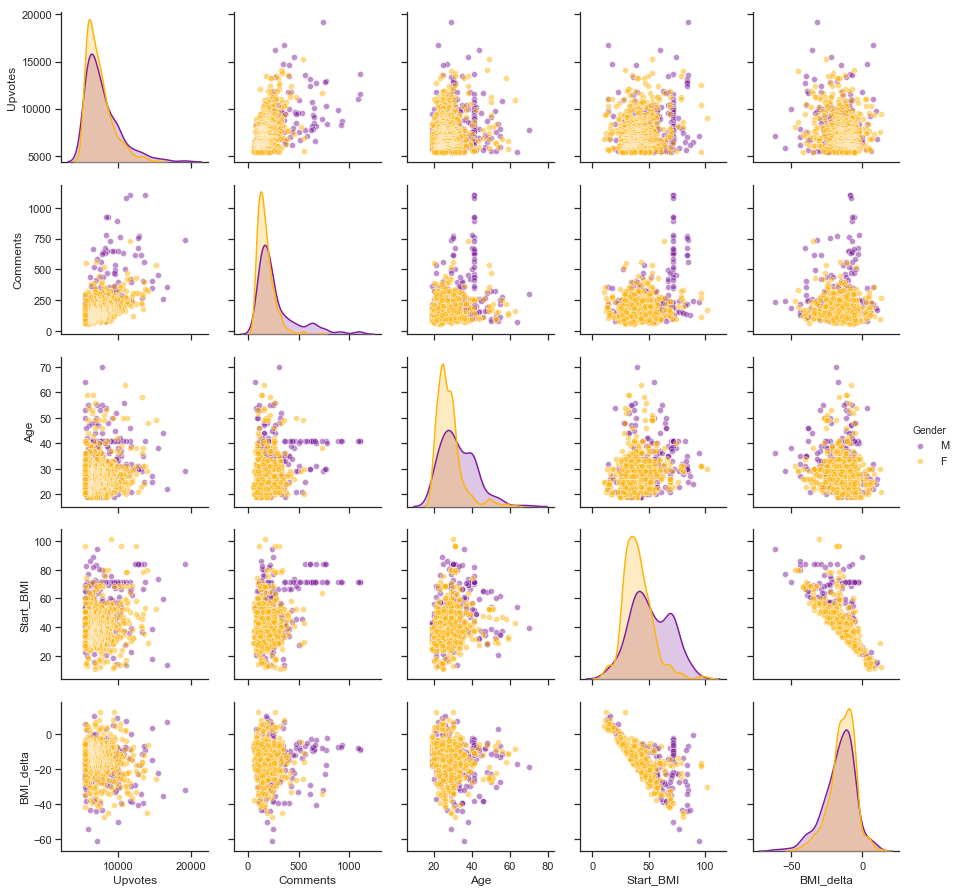

In [33]:
a = sns.pairplot(df, hue="Gender",
                 plot_kws=dict(alpha=0.5),
                 palette={'M':sns.xkcd_rgb["purple"],'F':sns.xkcd_rgb["amber"]},
                 vars=["Upvotes", "Comments","Age","Start_BMI","BMI_delta"]
                )


In [34]:
gender_bar = df.groupby('Gender').count()
bar_num = pd.DataFrame({'gender':['M','F'], 'num':[ gender_bar['Raw_Text']['M'],gender_bar['Raw_Text']['F']]})

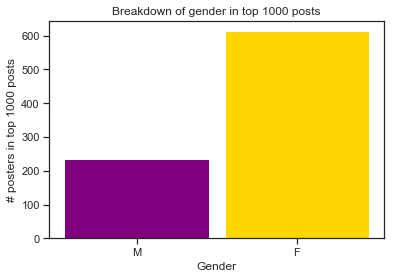

In [35]:
plt.bar(bar_num['gender'],bar_num['num'], color =['purple','#ffd700'], width = 0.9) 
plt.xlabel("Gender") 
plt.ylabel("# posters in top 1000 posts") 
plt.title("Breakdown of gender in top 1000 posts") 
plt.show()

In [36]:
top10 = df.head(10)

In [37]:
top10_gender_bar = top10.groupby('Gender').count()
top10_bar_num = pd.DataFrame({'gender':['M','F'],
                              'num':[top10_gender_bar['Raw_Text']['M'],top10_gender_bar['Raw_Text']['F']]
                             })

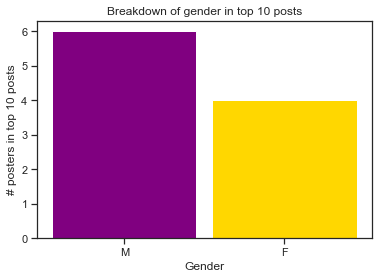

In [38]:
plt.bar(top10_bar_num['gender'],top10_bar_num['num'], color =['purple','#ffd700'], width = 0.9) 
plt.xlabel("Gender") 
plt.ylabel("# posters in top 10 posts") 
plt.title("Breakdown of gender in top 10 posts") 
plt.show()

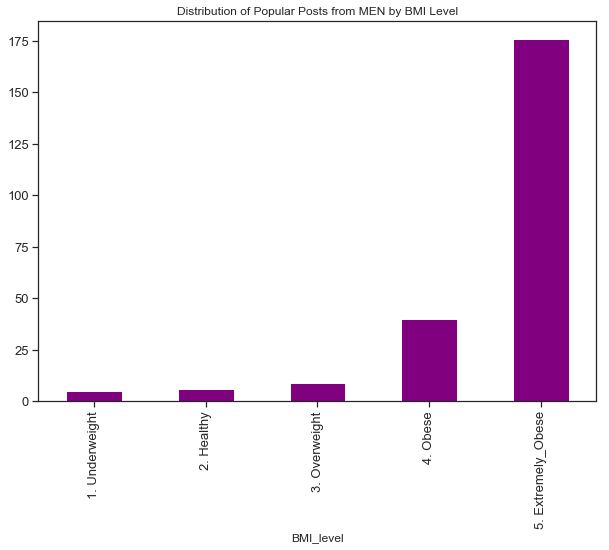

In [39]:
df_men = df[df['Gender'] == 'M']
ax = df_men.groupby('BMI_level').agg('Raw_Text').count().plot(kind='bar', x='BMI_level', y='Raw_Text',figsize=(10,7),color="purple", fontsize=13, title='Distribution of Popular Posts from MEN by BMI Level')

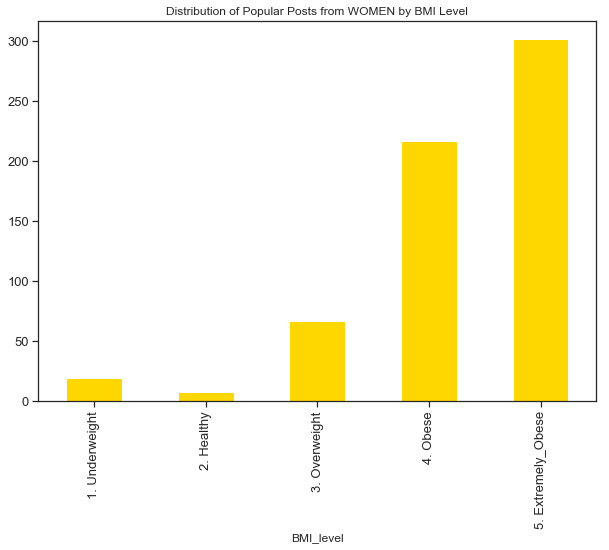

In [40]:
df_women = df[df['Gender'] == 'F']
df_women.groupby('BMI_level').agg('Raw_Text').count().plot(kind='bar', x='BMI_level', y='Raw_Text',figsize=(10,7),color="gold", fontsize=13, title='Distribution of Popular Posts from WOMEN by BMI Level')

### <i> Step 7) Math!</i>

#### Age vs Upvotes

In [41]:
corr, _ = pearsonr(df['Age'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.120


#### BMI Delta vs Upvotes

In [42]:
corr, _ = pearsonr(df['BMI_delta'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.170


#### Starting BMI vs Upvotes

In [43]:
corr, _ = pearsonr(df['Start_BMI'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.212


#### Comments vs Upvotes

In [44]:
corr, _ = pearsonr(df['Comments'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.487


#### Gender vs Upvotes

In [45]:
corr, _ = pearsonr(df['Gender_encoded'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)
# 0 = M, 1 = F

Pearsons correlation: -0.109


### Conclusions


- 849 rows out of 1000 were included in the analysis.

- Unsurprisingly, there were more women than men in the top 1000 most upvoted posts of the Progress Pics subreddit. However, it's possible that more women in general post to the subreddit. Further analysis would have to be done in order to disambiguate this point. 

- There were small positive correlations between Age vs. Upvotes (r=0.121) and Starting BMI vs. Upvotes (r=0.220). In other words, as age or starting BMI increased, so did the upvotes.

- Paradoxically, there was a small negative correlation between BMI Delta vs Upvotes (r=-0.177). In other words, if Patrick lost 15 points in BMI and John lost 10 points in BMI, it was more likely that John earned more upvotes. This may indicate that factors other than weight change affect upvotes.

- It was also interesting to see that there was a small negative correlation between being a woman and amount of upvotes. In other words, there were fewer men in the top 1000 but the men that were there had way more upvotes.

- There was a medium-sized positive correlation between Comments vs. Upvotes. Since both variables are basically proxies for engagement, it makes sense that they had r=0.491


### Next Steps

- There were twice as many women as men in the top 1000 submissions to this subreddit. However, it's possible that twice as many women post to the subreddit at all. (In other words, these numbers could indicate the demographic make-up of the subreddit, not the popularity of women posters.) I would like to explore the full dataset to see if that's the case.
- On Reddit, good conversation or engaging poster (OP) personalities sometimes lead to a higher upvote count. I would like to explore if there's a correlation between number of OP comments and popularity. (Are posters "rewarded" for being present or having a compelling backstory?)
- Some individuals in the subreddit have an ongoing series of posts to track their progress over time. I'd like to do some analysis on them to see if there's a link between post popularity, number of posts, amount of change between posts, and time posted. Since it's the same person, it would remove confounding variable of gender or attractiveness.
- Finally, my code above removed any metric units. I would liek to add kg and cm conversions so that I can use the full dataset.
